In [1]:
import cv2
from glob import glob
import numpy as np
import os
import json
import matplotlib.pyplot as plt
%matplotlib inline

# Make Panda Dataset from Videos

# Transfer VIA format to coco format

# Model Settings

In [2]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

import random

from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor, DefaultTrainer
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from detectron2.utils.visualizer import ColorMode

In [3]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("panda_train", {}, "panda_coco/annotations/panda_train.json", "panda_coco/train")
register_coco_instances("panda_val", {}, "panda_coco/annotations/panda_val.json", "panda_coco/val")

panda_metadata = MetadataCatalog.get("panda_train")
dataset_dicts = detectron2.data.datasets.load_coco_json(json_file='panda_coco/annotations/panda_train.json', image_root='./panda_coco/train', dataset_name='panda_train', extra_annotation_keys=None)

[04/18 09:39:30 d2.data.datasets.coco]: Loaded 120 images in COCO format from panda_coco/annotations/panda_train.json


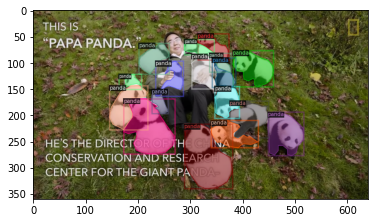

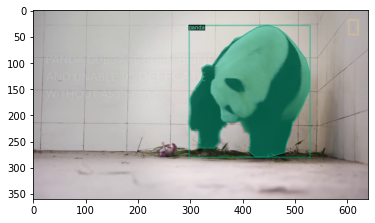

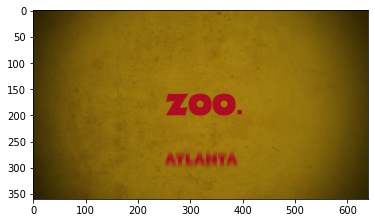

In [4]:
for i, d in enumerate(random.sample(list(dataset_dicts), 3)):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], 
                            metadata=panda_metadata, 
                            scale=0.5,
                            instance_mode=ColorMode.IMAGE_BW)
    vis = visualizer.draw_dataset_dict(d)
    image = vis.get_image()[:,:,::-1]
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.figure(i)
    plt.imshow(image)
    plt.show()

In [5]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_C4_1x.yaml"))
cfg.DATASETS.TRAIN = ("panda_train",)
cfg.DATASETS.TEST = ("panda_val",)
cfg.DATALOADER.NUM_WORKERS = 4
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_C4_1x.yaml")  # Let training initialize from model zoo
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1               # IMPORTANT HERE!  1 for panda
cfg.MODEL.ROI_HEADS.BATCH_SIZE_FOR_IMAGE = 512

cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025   # pick a good LR
cfg.SOLVER.WARMUP_ITERS = 100  # warmup lr before iter < 100
cfg.SOLVER.GAMMA = 0.3
cfg.SOLVER.STEPS = (300, 400)
cfg.SOLVER.MAX_ITER = 500   # 300 iterations seems good enough for this toy dataset; you may need to train longer for a practical dataset

cfg.INPUT.MAX_SIZE_TEST = 1280
cfg.INPUT.MAX_SIZE_TRAIN = 1280

In [6]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)

[04/18 09:39:43 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): ResNet(
    (stem): BasicStem(
      (conv1): Conv2d(
        3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
        (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
      )
    )
    (res2): Sequential(
      (0): BottleneckBlock(
        (shortcut): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
        )
        (conv1): Conv2d(
          64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (conv2): Conv2d(
          64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (conv3): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
 

[04/18 09:39:43 d2.data.datasets.coco]: Loaded 120 images in COCO format from panda_coco/annotations/panda_train.json
[04/18 09:39:43 d2.data.build]: Removed 22 images with no usable annotations. 98 images left.
[04/18 09:39:43 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|   panda    | 166          |
|            |              |
[04/18 09:39:43 d2.data.common]: Serializing 98 elements to byte tensors and concatenating them all ...
[04/18 09:39:43 d2.data.common]: Serialized dataset takes 0.05 MiB
[04/18 09:39:43 d2.data.detection_utils]: TransformGens used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1280, sample_style='choice'), RandomFlip()]
[04/18 09:39:43 d2.data.build]: Using training sampler TrainingSampler


'roi_heads.box_predictor.cls_score.weight' has shape (81, 2048) in the checkpoint but (2, 2048) in the model! Skipped.
'roi_heads.box_predictor.cls_score.bias' has shape (81,) in the checkpoint but (2,) in the model! Skipped.
'roi_heads.box_predictor.bbox_pred.weight' has shape (320, 2048) in the checkpoint but (4, 2048) in the model! Skipped.
'roi_heads.box_predictor.bbox_pred.bias' has shape (320,) in the checkpoint but (4,) in the model! Skipped.
'roi_heads.mask_head.predictor.weight' has shape (80, 256, 1, 1) in the checkpoint but (1, 256, 1, 1) in the model! Skipped.
'roi_heads.mask_head.predictor.bias' has shape (80,) in the checkpoint but (1,) in the model! Skipped.


In [7]:
trainer.train()

[04/18 09:39:43 d2.engine.train_loop]: Starting training from iteration 0
[04/18 09:40:03 d2.utils.events]:  eta: 0:07:47  iter: 19  total_loss: 1.721  loss_cls: 0.636  loss_box_reg: 0.214  loss_mask: 0.688  loss_rpn_cls: 0.103  loss_rpn_loc: 0.073  time: 0.9761  data_time: 0.0103  lr: 0.000048  max_mem: 4926M
[04/18 09:40:22 d2.utils.events]:  eta: 0:07:30  iter: 39  total_loss: 1.430  loss_cls: 0.282  loss_box_reg: 0.236  loss_mask: 0.621  loss_rpn_cls: 0.110  loss_rpn_loc: 0.106  time: 0.9798  data_time: 0.0026  lr: 0.000098  max_mem: 4976M
[04/18 09:40:42 d2.utils.events]:  eta: 0:07:12  iter: 59  total_loss: 1.218  loss_cls: 0.215  loss_box_reg: 0.287  loss_mask: 0.506  loss_rpn_cls: 0.099  loss_rpn_loc: 0.084  time: 0.9825  data_time: 0.0027  lr: 0.000148  max_mem: 4976M
[04/18 09:41:02 d2.utils.events]:  eta: 0:06:54  iter: 79  total_loss: 1.046  loss_cls: 0.171  loss_box_reg: 0.257  loss_mask: 0.392  loss_rpn_cls: 0.074  loss_rpn_loc: 0.074  time: 0.9859  data_time: 0.0028  lr:

In [8]:
%load_ext tensorboard
%tensorboard --logdir output

ERROR: Timed out waiting for TensorBoard to start. It may still be running as pid 4628.

# Inference & Evaluation trained model

## Inference

In [25]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7
cfg.DATASETS.TEST = ("panda_val",)
predictor = DefaultPredictor(cfg)

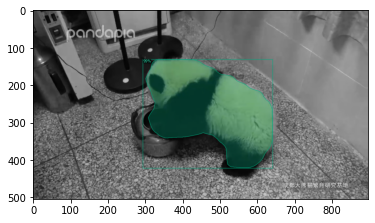

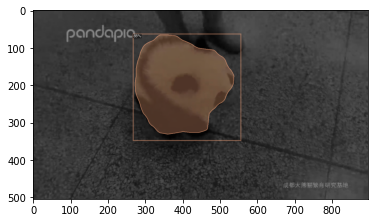

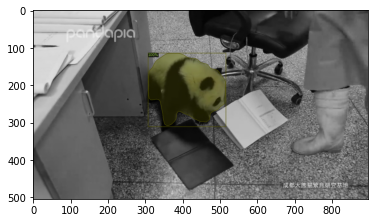

In [26]:
from detectron2.utils.visualizer import ColorMode
image_dirs = glob('./panda_coco/val/*.jpg')
metadata = MetadataCatalog.get("panda_val")
for i, image_dir in enumerate(random.sample(image_dirs, 3)):
    im = cv2.imread(image_dir)
    outputs = predictor(im)
    v = Visualizer(im[:,:,::-1],
                  metadata=metadata,
                  scale=0.7,
                  instance_mode=ColorMode.IMAGE_BW)
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    image = v.get_image()[:,:,::-1]
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.figure(i)
    plt.imshow(image)
    plt.show()

## Evaluate

In [27]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("panda_val", cfg, False, output_dir='./output')
val_loader = build_detection_test_loader(cfg, "panda_val")
inference_on_dataset(trainer.model, val_loader, evaluator)

[04/18 00:13:10 d2.data.datasets.coco]: Loaded 20 images in COCO format from panda_coco/annotations/panda_val.json
[04/18 00:13:10 d2.data.common]: Serializing 20 elements to byte tensors and concatenating them all ...
[04/18 00:13:10 d2.data.common]: Serialized dataset takes 0.01 MiB
[04/18 00:13:10 d2.evaluation.evaluator]: Start inference on 20 images
[04/18 00:13:11 d2.evaluation.evaluator]: Inference done 11/20. 0.1263 s / img. ETA=0:00:01
[04/18 00:13:13 d2.evaluation.evaluator]: Total inference time: 0:00:02.575999 (0.171733 s / img per device, on 1 devices)
[04/18 00:13:13 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:02 (0.156407 s / img per device, on 1 devices)
[04/18 00:13:13 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[04/18 00:13:13 d2.evaluation.coco_evaluation]: Saving results to ./output/coco_instances_results.json
[04/18 00:13:13 d2.evaluation.coco_evaluation]: Evaluating predictions ...
Loading and preparing results...
DO

OrderedDict([('bbox',
              {'AP': 46.99390578098369,
               'AP50': 72.18084885411619,
               'AP75': 49.76102411572492,
               'APs': nan,
               'APm': 24.935289957567182,
               'APl': 54.71198746114225}),
             ('segm',
              {'AP': 48.9941143805026,
               'AP50': 71.28075884511529,
               'AP75': 61.32597413402805,
               'APs': nan,
               'APm': 28.15378680725215,
               'APl': 56.83400682268709})])